In [1]:
import os
import sys

repo_name = "NeuroKit"
repo_path = os.getcwd()
base_dir = os.path.basename(repo_path)
while base_dir != repo_name:
    repo_path = os.path.dirname(os.path.abspath(repo_path))
    base_dir = os.path.basename(repo_path)
    
submodule_path = os.path.join(repo_path)
sys.path.insert(0, submodule_path)

In [2]:
# Load the NeuroKit package and other useful packages

import neurokit2 as nk
import numpy as np
import matplotlib.pyplot as plt

from neurokit2.signal.signal_formatpeaks import _signal_formatpeaks_sanitize

In [3]:
# This "decorative" cell should be hidden from the docs once this is implemented:
# https://github.com/microsoft/vscode-jupyter/issues/1182 
plt.rcParams['figure.figsize'] = [15, 5]  # Bigger images
plt.rcParams['font.size']= 14

This example can be referenced by [citing the package](https://neuropsychology.github.io/NeuroKit/cite_us.html).

This example shows how to use NeuroKit to extract and fix R-Peaks (heartbeat locations) from an electrocardiogram (ECG).



## Download Dataset

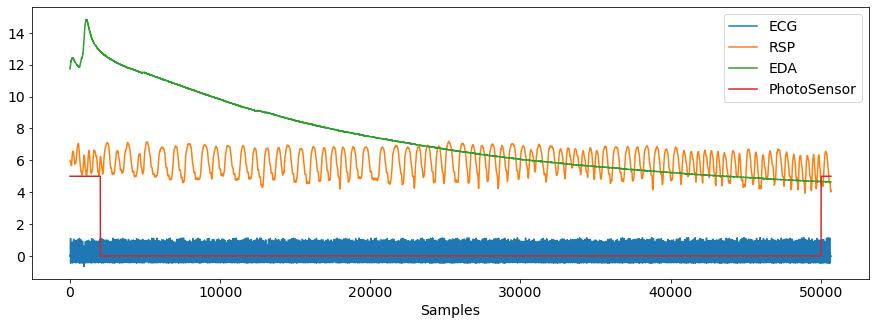

In [4]:
# load biosignal data
data = nk.data(dataset="bio_resting_8min_100hz")
data.plot()
plt.xlabel("Samples")
plt.show()

In [5]:
data.head() # print first 5 rows

,ECG,RSP,EDA,PhotoSensor
0,0.000763,5.996094,11.734010,5
1,-0.000610,5.990601,11.746217,5
2,0.000763,5.990906,11.752320,5
3,0.002289,5.985718,11.756898,5
4,0.005341,5.981750,11.770631,5


You can see that it consists of four different signals, pertaining to ECG, RSP (respiration), EDA (electrodermal activity) and a photosensor. For the purposes of this example, we'll just use the ECG signal, so let's extract it in the shape of a vector (i.e., a one-dimensional array).



In [6]:
# get ECG channel
ecg_data_all = data["ECG"].values
# sampling rate in file name
sampling_rate = 100

The seed of the random number generator will be set so that the results are reproducible.

In [7]:
# set the seed for the random number generator
# used for randomly selecting a subset of the recording
# and also later used for distorting the ECG data
seed = 42
np.random.seed(seed)

Now we can select a shorter subset of the 8-minute recording, which will be easier to visualize.

In [12]:
# select a 30-second segment
num_seconds = 30
first_sample = np.random.randint(0, len(ecg_data_all) - num_seconds * sampling_rate)
last_sample = first_sample + num_seconds * sampling_rate
ecg_orig = ecg_data_all[first_sample:last_sample]

## Process ECG signal



Once you have a raw ECG signal in the shape of a vector (i.e., a one-dimensional array), or a list, you can use ecg_process() to process it.

In [13]:
signals_orig, info_orig = nk.ecg_process(ecg_orig, sampling_rate=sampling_rate)

*Note: It is critical that you specify the correct sampling rate of your signal throughout many processing functions, as this allows NeuroKit to have a time reference.*

This function outputs two elements, a dataframe containing the different signals (e.g., the raw signal, cleaned signal, the heart rate etc.), and a dictionary containing information about the signals (peak locations, sampling rate).

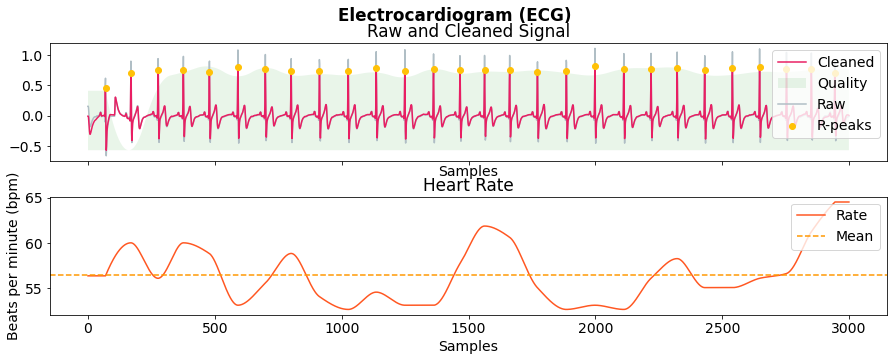

In [14]:
nk.ecg_plot(signals_orig)

In [15]:
info_orig

{'ECG_R_Peaks': array([  69,  169,  276,  376,  478,  591,  699,  801,  912, 1026, 1136,
        1249, 1362, 1466, 1563, 1662, 1771, 1885, 1998, 2112, 2219, 2322,
        2431, 2540, 2647, 2753, 2851, 2944]),
 'sampling_rate': 100}

It looks like this signal is pretty clean and all the peaks were correctly detected, so now we will add artifacts to simulate a noisy ECG signal where the peaks may have to be corrected.

## Distort original ECG signal

In [38]:
# distort the ECG data
artifacts_amplitude = 3
artifacts_number = 4
artifacts_frequency = 5

ecg_dist = ecg_orig.copy()
ecg_dist = nk.signal_distort(
    ecg_dist,
    sampling_rate=sampling_rate,
    artifacts_amplitude=artifacts_amplitude,
    artifacts_frequency=artifacts_frequency,
    artifacts_number=artifacts_number,
    random_state=seed,
)

In [39]:
# process distorted data
signals_dist, info_dist = nk.ecg_process(ecg_dist, sampling_rate=sampling_rate)

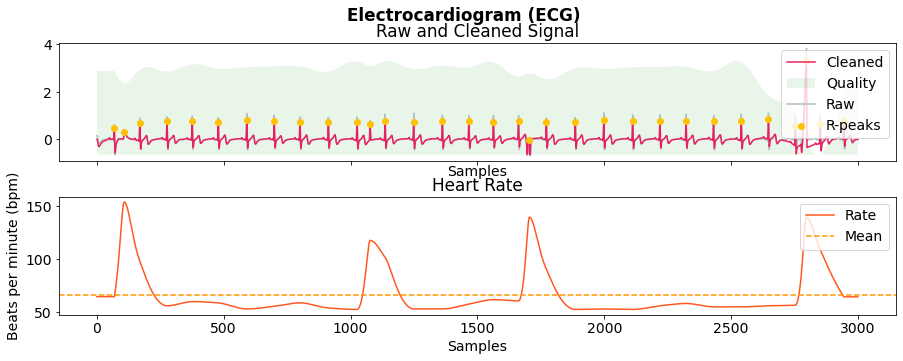

In [40]:
# plot distorted data
nk.ecg_plot(signals_dist)
#fig = plt.gcf()
#ax_list = fig.axes
#ax_list[0].set_ylim([-1.5,1.5])

## Correct the peaks in the distorted data

In [41]:
peaks = info_dist["ECG_R_Peaks"]

Here, to determine which interval size is acceptable, we will use the minimum and maximum R-R intervals after removing outliers.

In [42]:
interval = nk.signal_period(peaks, sampling_rate=sampling_rate)
interval_without_outliers = interval[np.invert(nk.find_outliers(interval))]
interval_min = np.min(interval_without_outliers)
print(
    "Minimum interval: "
    + str(interval_min)
    + " seconds, i.e. "
    + str(int(60 / interval_min))
    + " BPM"
)
interval_max = np.max(interval_without_outliers)
print(
    "Maximum interval: "
    + str(interval_max)
    + " seconds, i.e. "
    + str(int(60 / interval_max))
    + " BPM"
)

Minimum interval: 0.43 seconds, i.e. 139 BPM
Maximum interval: 1.14 seconds, i.e. 52 BPM


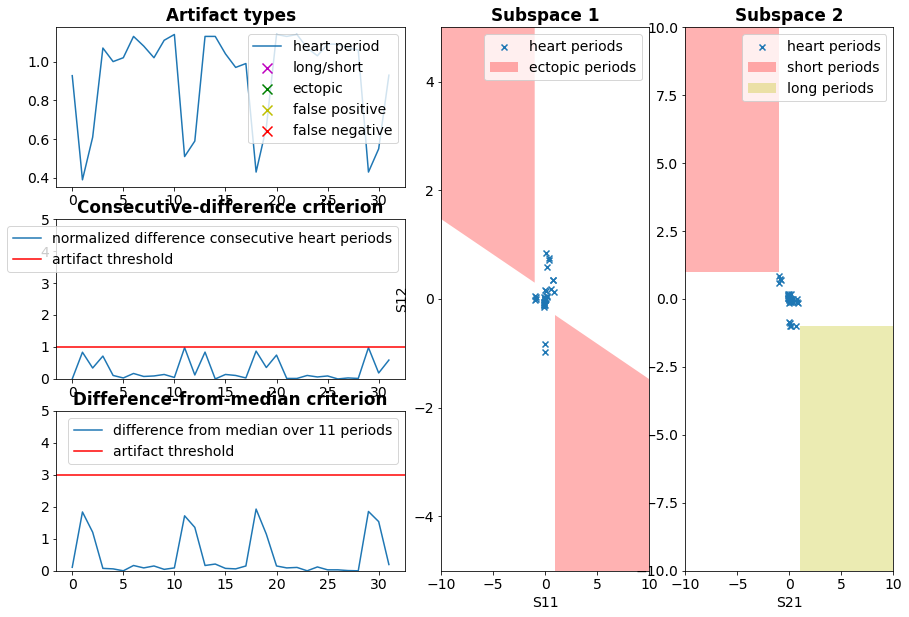

In [45]:
_, peaks_corrected = nk.signal_fixpeaks(
        peaks=peaks, method="Kubios", sampling_rate=sampling_rate, show=True
    )

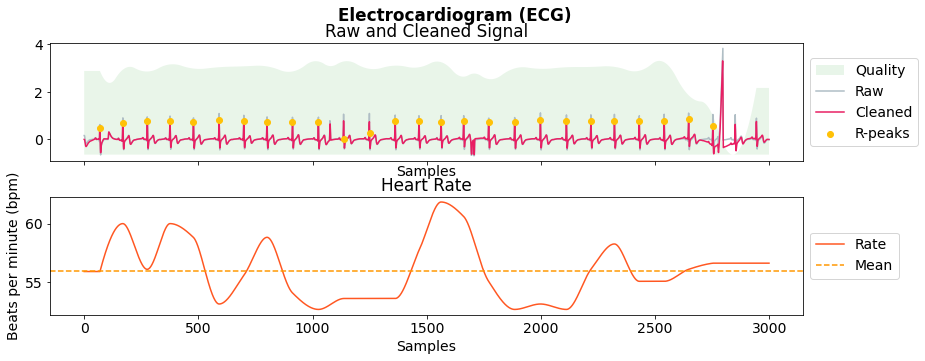

In [86]:
signals_dist_cor = signals_dist.copy()
signals_dist_cor["ECG_R_Peaks"] = nk.signal_formatpeaks(
    {"Peaks Corrected": peaks_corrected}, desired_length=len(signals_dist_cor)
)
signals_dist_cor["ECG_Rate"] = nk.signal_rate(
    peaks_corrected, sampling_rate=sampling_rate, desired_length=len(signals_dist_cor),
)
# plot distorted data
nk.ecg_plot(signals_dist_cor)
fig = plt.gcf()
ax_list = fig.axes

"""
ax_list[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=4, fancybox=True, shadow=True)
ax_list[1].legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=4, fancybox=True, shadow=True)
"""
for ax in ax_list:
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.9, box.height])

    # Put a legend to the right of the current axis
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))


# ax_list[0].set_ylim([-1.5,1.5])
plt.show()

In [ ]:
signals_dist_cor = signals_dist.copy()
signals_dist_cor["ECG_R_Peaks"] = nk.signal_formatpeaks(
            {"Peaks Corrected": peaks_corrected}, desired_length=len(signals_dist_cor)
        )
signals_dist_cor["ECG_Rate"] = nk.signal_rate(
        peaks_corrected,
        sampling_rate=sampling_rate,
        desired_length=len(signals_dist_cor),
)
# plot distorted data
nk.ecg_plot(signals_dist_cor)
fig = plt.gcf()
ax_list = fig.axes
#ax_list[0].set_ylim([-1.5,1.5])
plt.show()

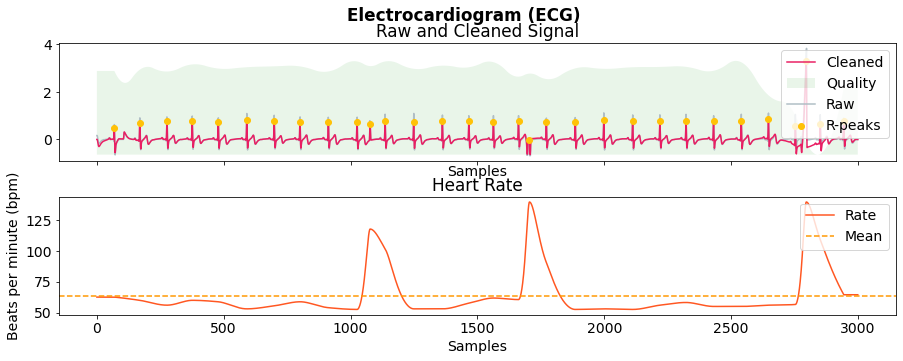

In [87]:
peaks_corrected = nk.signal_fixpeaks(
            peaks=peaks,
            method="neurokit",
            sampling_rate=sampling_rate,
            relative_interval_min=-2,
            relative_interval_max=2,
)

signals_dist_cor = signals_dist.copy()
signals_dist_cor["ECG_R_Peaks"] = nk.signal_formatpeaks(
            {"Peaks Corrected": peaks_corrected}, desired_length=len(signals_dist_cor)
        )
signals_dist_cor["ECG_Rate"] = nk.signal_rate(
        peaks_corrected,
        sampling_rate=sampling_rate,
        desired_length=len(signals_dist_cor),
)
# plot distorted data
nk.ecg_plot(signals_dist_cor)
fig = plt.gcf()
ax_list = fig.axes
#ax_list[0].set_ylim([-1.5,1.5])
plt.show()

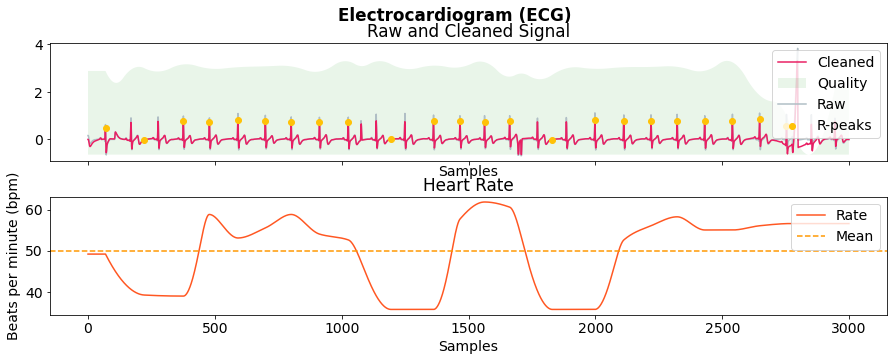

In [88]:
peaks_corrected = nk.signal_fixpeaks(
            peaks=peaks,
            method="neurokit",
            sampling_rate=sampling_rate,
            relative_interval_min=-2,
            relative_interval_max=2,
            robust=True
)

signals_dist_cor = signals_dist.copy()
signals_dist_cor["ECG_R_Peaks"] = nk.signal_formatpeaks(
            {"Peaks Corrected": peaks_corrected}, desired_length=len(signals_dist_cor)
        )
signals_dist_cor["ECG_Rate"] = nk.signal_rate(
        peaks_corrected,
        sampling_rate=sampling_rate,
        desired_length=len(signals_dist_cor),
)
# plot distorted data
nk.ecg_plot(signals_dist_cor)
fig = plt.gcf()
ax_list = fig.axes
#ax_list[0].set_ylim([-1.5,1.5])
plt.show()

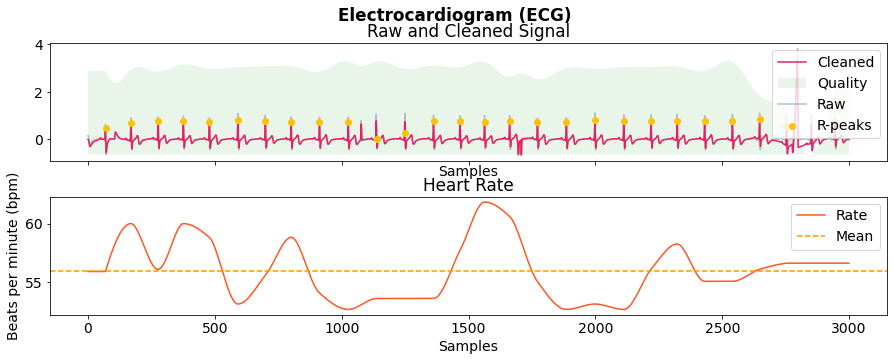

In [89]:
bpm_max = 100
bpm_min = 40
interval_min = 60/bpm_max
interval_max = 60/bpm_min

peaks_corrected = nk.signal_fixpeaks(
            peaks=peaks,
            method="neurokit",
            sampling_rate=sampling_rate,
            interval_min=interval_min,
            interval_max=interval_max,
)

signals_dist_cor = signals_dist.copy()
signals_dist_cor["ECG_R_Peaks"] = nk.signal_formatpeaks(
            {"Peaks Corrected": peaks_corrected}, desired_length=len(signals_dist_cor)
        )
signals_dist_cor["ECG_Rate"] = nk.signal_rate(
        peaks_corrected,
        sampling_rate=sampling_rate,
        desired_length=len(signals_dist_cor),
)
# plot distorted data
nk.ecg_plot(signals_dist_cor)
fig = plt.gcf()
ax_list = fig.axes
#ax_list[0].set_ylim([-1.5,1.5])
plt.show()

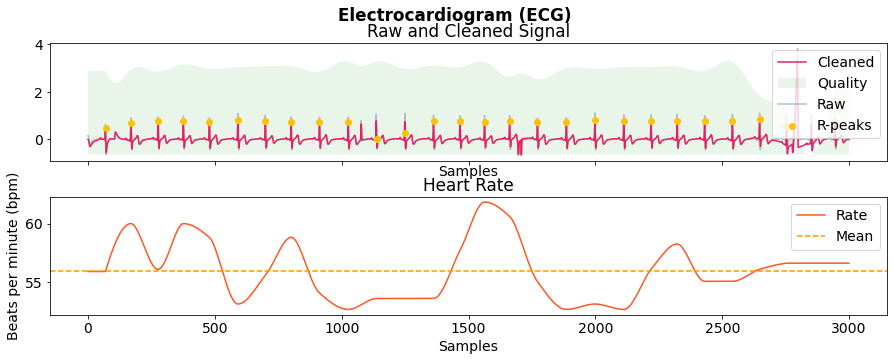

In [90]:
peaks_corrected = nk.signal_fixpeaks(
            peaks=peaks,
            method="neurokit",
            sampling_rate=sampling_rate,
            interval_min=0.6,
            interval_max=1.5,
)

signals_dist_cor = signals_dist.copy()
signals_dist_cor["ECG_R_Peaks"] = nk.signal_formatpeaks(
            {"Peaks Corrected": peaks_corrected}, desired_length=len(signals_dist_cor)
        )
signals_dist_cor["ECG_Rate"] = nk.signal_rate(
        peaks_corrected,
        sampling_rate=sampling_rate,
        desired_length=len(signals_dist_cor),
)
# plot distorted data
nk.ecg_plot(signals_dist_cor)
fig = plt.gcf()
ax_list = fig.axes
#ax_list[0].set_ylim([-1.5,1.5])
plt.show()

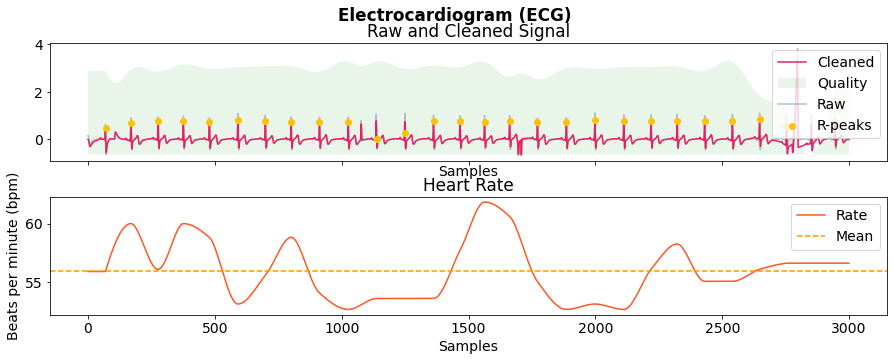

In [91]:
peaks_corrected = nk.signal_fixpeaks(
            peaks=peaks,
            method="neurokit",
            sampling_rate=sampling_rate,
            interval_min=interval_min,
            interval_max=interval_max,
)

signals_dist_cor = signals_dist.copy()
signals_dist_cor["ECG_R_Peaks"] = nk.signal_formatpeaks(
            {"Peaks Corrected": peaks_corrected}, desired_length=len(signals_dist_cor)
        )
signals_dist_cor["ECG_Rate"] = nk.signal_rate(
        peaks_corrected,
        sampling_rate=sampling_rate,
        desired_length=len(signals_dist_cor),
)
# plot distorted data
nk.ecg_plot(signals_dist_cor)
fig = plt.gcf()
ax_list = fig.axes
#ax_list[0].set_ylim([-1.5,1.5])
plt.show()

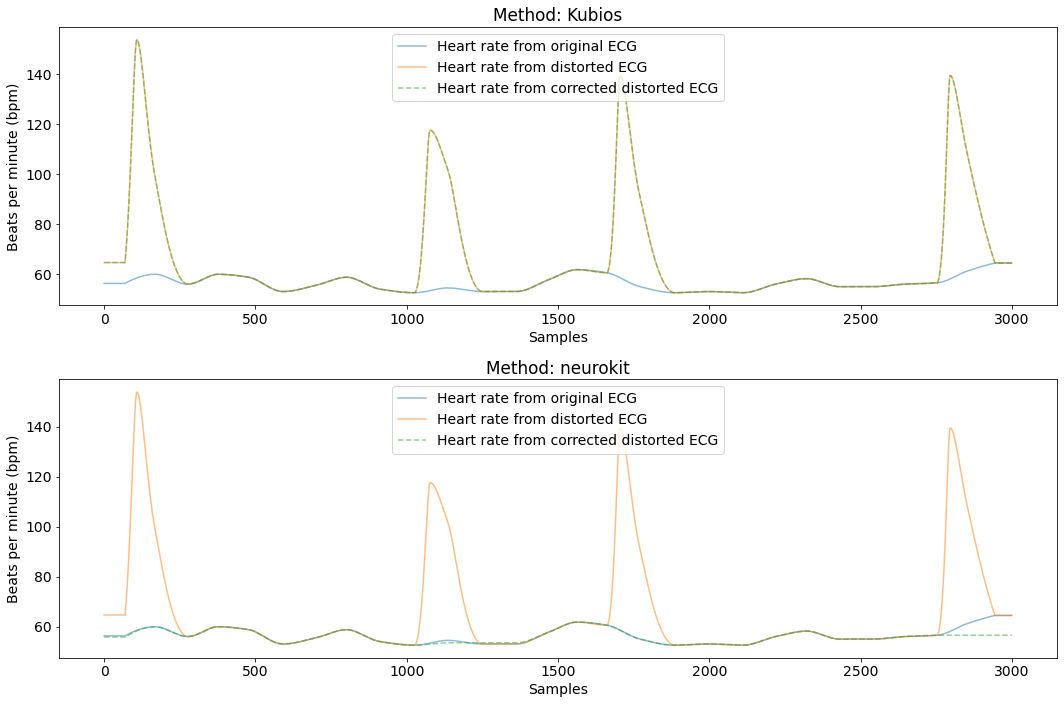

In [92]:
methods = ["Kubios", "neurokit"]
fig, axes = plt.subplots(nrows=len(methods), ncols=1, figsize=(15, 10))

for i in range(len(methods)):
    method = methods[i]
    if method == "Kubios":
        _, peaks_corrected = nk.signal_fixpeaks(
            peaks=peaks, method=method, sampling_rate=sampling_rate
        )
    else:
        peaks_corrected = nk.signal_fixpeaks(
            peaks=peaks,
            method=method,
            sampling_rate=sampling_rate,
            interval_min=interval_min,
            interval_max=interval_max,
        )

    ax = axes[i]
    ax.plot(signals_orig["ECG_Rate"], alpha=0.5)
    ax.plot(signals_dist["ECG_Rate"], alpha=0.5)
    rate_corrected = nk.signal_rate(
        peaks_corrected,
        sampling_rate=sampling_rate,
        desired_length=len(signals_dist["ECG_Rate"]),
    )
    ax.plot(rate_corrected, alpha=0.5, linestyle="--")
    ax.legend(
        [
            "Heart rate from original ECG",
            "Heart rate from distorted ECG",
            "Heart rate from corrected distorted ECG",
        ]
    )
    ax.set_title("Method: " + method)
    ax.set_xlabel("Samples")
    ax.set_ylabel("Beats per minute (bpm)")
plt.tight_layout()
plt.show()

In this example, both methods corrected some of the peaks, making the heart rate closer to that of the original ECG, but still not perfectly. Let's visualize the peak correction.

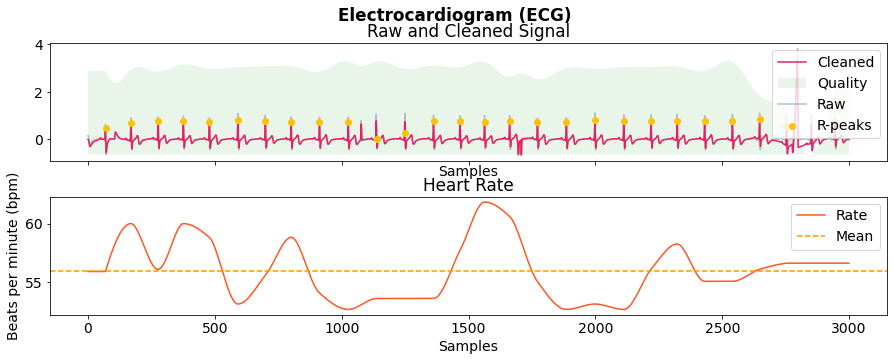

In [93]:
signals_dist_cor = signals_dist.copy()
signals_dist_cor["ECG_R_Peaks"] = nk.signal_formatpeaks(
            {"Peaks Corrected": peaks_corrected}, desired_length=len(signals_dist_cor)
        )
signals_dist_cor["ECG_Rate"] = nk.signal_rate(
        peaks_corrected,
        sampling_rate=sampling_rate,
        desired_length=len(signals_dist_cor),
)
# plot distorted data
nk.ecg_plot(signals_dist_cor)
fig = plt.gcf()
ax_list = fig.axes
#ax_list[0].set_ylim([-1.5,1.5])
plt.show()

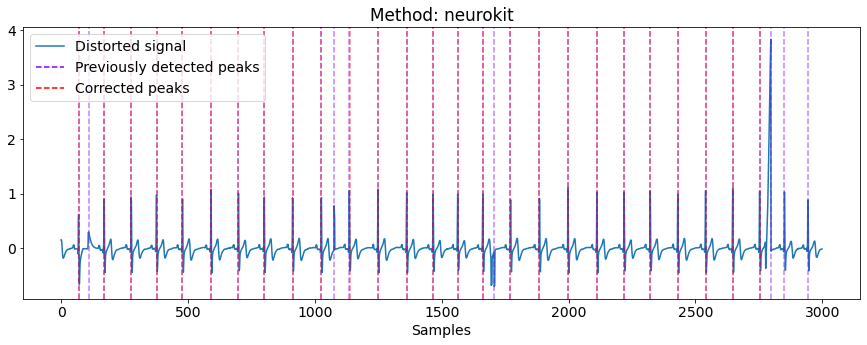

In [96]:
# Visualize R-peaks in ECG signal
plot = nk.events_plot([peaks, peaks_corrected], signals_dist["ECG_Raw"])
# Display only one legend per event type
handles, labels = plt.gca().get_legend_handles_labels()
label_map = {"Signal": "Distorted signal",
               "0":"Previously detected peaks",
               "1":"Corrected peaks"}
mapped_labels = [label_map[label] for label in labels]
newLabels, newHandles = [], []
for handle, label in zip(handles, mapped_labels):
    if label not in newLabels:
        newLabels.append(label)
        newHandles.append(handle)
plt.legend(newHandles, newLabels)
plt.title("Method: " + method)

plt.xlabel("Samples")
ax_list = plt.gcf().axes
for l in plt.gcf().gca().lines[1:]:
    l.set_alpha(0.5)
#ax_list[0].set_ylim([-1.5,1.5])
#ax_list[0].set_xlim([500,1000])

plt.show()

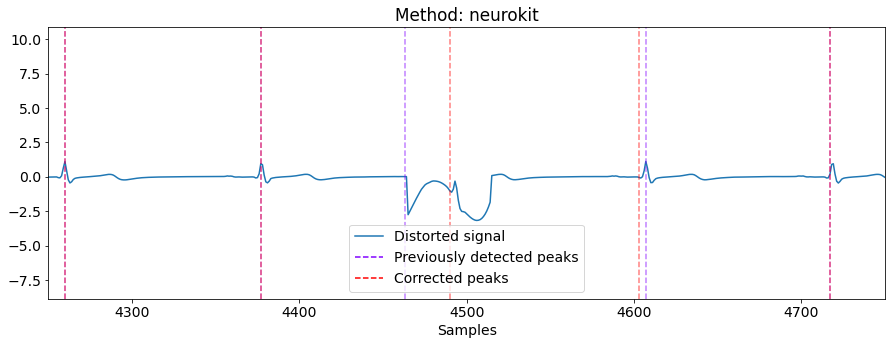

In [48]:
# Visualize R-peaks in ECG signal
plot = nk.events_plot([peaks, peaks_corrected], signals_dist["ECG_Raw"])
# Display only one legend per event type
handles, labels = plt.gca().get_legend_handles_labels()
label_map = {"Signal": "Distorted signal",
               "0":"Previously detected peaks",
               "1":"Corrected peaks"}
mapped_labels = [label_map[label] for label in labels]
newLabels, newHandles = [], []
for handle, label in zip(handles, mapped_labels):
    if label not in newLabels:
        newLabels.append(label)
        newHandles.append(handle)
plt.legend(newHandles, newLabels)
plt.title("Method: " + method)

plt.xlabel("Samples")
ax_list = plt.gcf().axes
for l in plt.gcf().gca().lines[1:]:
    l.set_alpha(0.5)
#ax_list[0].set_ylim([-1.5,1.5])
ax_list[0].set_xlim([4250, 4750])

plt.show()

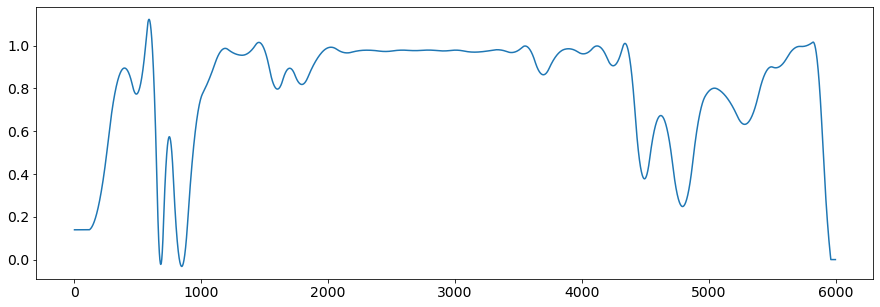

In [52]:
plt.plot(signals_dist["ECG_Quality"].values)